In [ ]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

from torch.utils.tensorboard import SummaryWriter

from sklearn.metrics import confusion_matrix

device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [ ]:
class ArtCNN(nn.Module):
    def __init__(self):
        super(ArtCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool = nn.MaxPool2d(2, 2)
        
        # 224x224 image becomes 14x14:
        # flattened feature map size: 256 * 14 * 14
        self.fc1 = nn.Linear(256 * 14 * 14, 64) 
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 5)  # output layer for 5 classes

    def forward(self, x):
        x = self.pool(self.conv1(x))  # 224 -> 112
        x = self.pool(self.conv2(x))  # 112 -> 56
        x = self.pool(self.conv3(x))  # 56 -> 28
        x = self.pool(self.conv4(x))  # 28 -> 14
        x = x.view(x.size(0), -1)
        embedding = torch.relu(self.fc1(x))
        embedding = self.dropout(embedding)
        logits = self.fc2(embedding)
        return logits, embedding

In [ ]:
def compute_mean_std(dataset):
    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False, num_workers=8)
    mean = 0.
    std = 0.
    total_images = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples
    mean /= total_images
    std /= total_images
    return mean, std

transform_simple = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
dataset = torchvision.datasets.ImageFolder(root=r'art500k_period', transform=transform_simple)
mean, std = compute_mean_std(dataset)

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

full_dataset = torchvision.datasets.ImageFolder(
    root=r'art500k_period', 
    transform=transform_simple
)
indices = list(range(len(full_dataset)))
np.random.shuffle(indices)
train_size = int(0.8 * len(full_dataset))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

train_dataset = torchvision.datasets.ImageFolder(
    root=r'art500k_period', 
    transform=train_transform
)
test_dataset = torchvision.datasets.ImageFolder(
    root=r'art500k_period', 
    transform=test_transform
)

trainset_simple = torch.utils.data.Subset(train_dataset, train_indices)
testset_simple = torch.utils.data.Subset(test_dataset, test_indices)

In [ ]:
class_distribution = {0: 0.07, 1: 0.38, 2: 0.25, 3: 0.15, 4: 0.15}
train_labels = [train_dataset.samples[i][1] for i in trainset_simple.indices]
train_sample_weights = [1.0 / class_distribution[label]**0.5 for label in train_labels]

sampler = torch.utils.data.WeightedRandomSampler(
    train_sample_weights, num_samples=len(train_sample_weights), replacement=True
)

trainloader_simple = torch.utils.data.DataLoader(
    trainset_simple, batch_size=32, sampler=sampler, num_workers=12
)
testloader_simple = torch.utils.data.DataLoader(
    testset_simple, batch_size=32, shuffle=False, num_workers=12
)

print("Simple model data loaded: train size =", len(trainset_simple),
      ", test size =", len(testset_simple))

Simple model data loaded: train size = 38424 , test size = 9606


In [ ]:
simple_model = ArtCNN().to(device)

loss_weights = torch.tensor([
    1/np.sqrt(0.07).item(), 1/np.sqrt(0.38).item(), 1/np.sqrt(0.25).item(), 1/np.sqrt(0.15).item(), 1/np.sqrt(0.15).item()
], dtype=torch.float)
loss_weights = loss_weights / loss_weights.mean()
criterion = nn.CrossEntropyLoss(weight=loss_weights.to(device))
optimizer = optim.Adam(simple_model.parameters(), lr=0.0001)

train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []

num_epochs = 50
print("Training ArtCNN...")
for epoch in range(num_epochs):
    epoch_time = time.time()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    simple_model.train()  
    for inputs, labels in trainloader_simple:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()          
        outputs, _ = simple_model(inputs)  
        loss = criterion(outputs, labels)
        loss.backward()               
        optimizer.step()           

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    epoch_loss = running_loss / len(trainset_simple)
    train_accuracy = 100 * correct_train / total_train

    # evaluate on test data
    simple_model.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in testloader_simple:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs, _ = simple_model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()
    epoch_test_loss = test_loss / len(testset_simple)
    test_accuracy = 100 * correct_test / total_test
    epoch_duration = time.time() - epoch_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {epoch_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%, Time: {epoch_duration:.2f}")
    train_loss_list.append(epoch_loss)
    train_acc_list.append(train_accuracy)
    test_loss_list.append(epoch_test_loss)
    test_acc_list.append(test_accuracy)
    
print("Finished training the CNN.")

Training ArtCNN...
Epoch [1/50], Train Loss: 1.5398, Train Acc: 22.82%, Test Loss: 1.4544, Test Acc: 25.26%, Time: 54.08
Epoch [2/50], Train Loss: 1.4854, Train Acc: 23.49%, Test Loss: 1.4530, Test Acc: 25.89%, Time: 53.96
Epoch [3/50], Train Loss: 1.4619, Train Acc: 24.43%, Test Loss: 1.4277, Test Acc: 19.93%, Time: 54.42
Epoch [4/50], Train Loss: 1.4529, Train Acc: 25.04%, Test Loss: 1.4156, Test Acc: 25.77%, Time: 54.85
Epoch [5/50], Train Loss: 1.4435, Train Acc: 25.35%, Test Loss: 1.4050, Test Acc: 25.47%, Time: 54.11
Epoch [6/50], Train Loss: 1.4353, Train Acc: 24.57%, Test Loss: 1.4008, Test Acc: 31.45%, Time: 53.72
Epoch [7/50], Train Loss: 1.4226, Train Acc: 25.90%, Test Loss: 1.3930, Test Acc: 30.87%, Time: 53.92
Epoch [8/50], Train Loss: 1.4124, Train Acc: 26.23%, Test Loss: 1.4067, Test Acc: 24.83%, Time: 53.73
Epoch [9/50], Train Loss: 1.4054, Train Acc: 29.13%, Test Loss: 1.3868, Test Acc: 31.18%, Time: 53.34
Epoch [10/50], Train Loss: 1.3979, Train Acc: 32.73%, Test Loss

In [ ]:
simple_model.eval() 
correct = 0
total = 0

all_embeddings_simple = []
all_labels_simple = []
all_true = []
all_preds = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testloader_simple):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs, embeddings = simple_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_true.extend(labels.cpu().numpy())
        if len(all_embeddings_simple) < 500:
            all_embeddings_simple.append(embeddings.cpu())
            all_labels_simple.append(labels.cpu())
            
accuracy_simple = 100 * correct / total
print(f"Simple CNN Test Accuracy: {accuracy_simple:.2f}%")

embeddings_custom = torch.cat(all_embeddings_simple, dim=0)[:500]
labels_custom = torch.cat(all_labels_simple, dim=0)[:500]


Simple CNN Test Accuracy: 41.47%


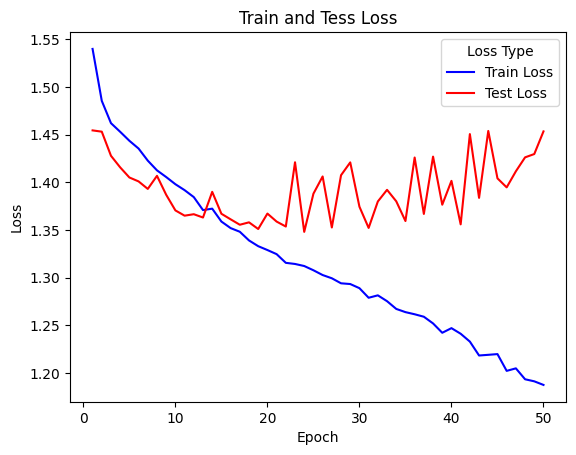

In [ ]:
data = pd.DataFrame({
    'Epoch': range(1, len(test_loss_list) + 1),
    'Train Loss': train_loss_list,
    'Test Loss': test_loss_list
})

data_long = data.melt('Epoch', var_name='Loss Type', value_name='Loss')

sns.lineplot(x='Epoch', y='Loss', hue='Loss Type',  palette=['b', 'r'], data=data_long)

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Tess Loss')
plt.legend(title='Loss Type')
plt.show()

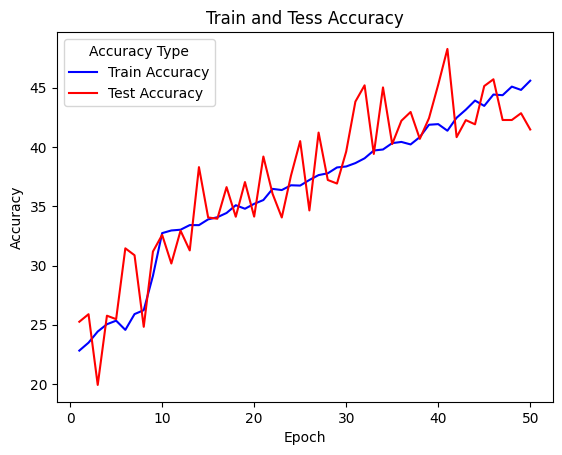

In [ ]:
data = pd.DataFrame({
    'Epoch': range(1, len(test_loss_list) + 1),
    'Train Accuracy': train_acc_list,
    'Test Accuracy': test_acc_list
})

data_long = data.melt('Epoch', var_name='Accuracy Type', value_name='Accuracy')

sns.lineplot(x='Epoch', y='Accuracy', hue='Accuracy Type',  palette=['b', 'r'], data=data_long)

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Tess Accuracy')

plt.legend(title='Accuracy Type')
plt.show()

/tmp/ipykernel_4044303/282253075.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df, palette='cool')


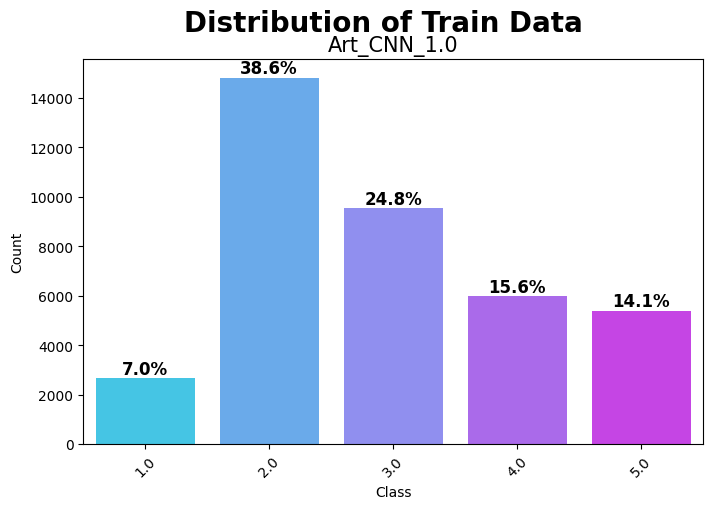

In [ ]:
class_counts = {class_name: 0 for class_name in dataset.classes}

for idx in trainset_simple.indices: 
    label = dataset.targets[idx] 
    class_counts[dataset.classes[label]] += 1

total_train_samples = sum(class_counts.values())

df = pd.DataFrame(list(class_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Class', y='Count', data=df, palette='cool')

for p in ax.patches:
    percentage = (p.get_height() / total_train_samples) * 100  
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.suptitle("Distribution of Train Data", fontsize=20, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

/tmp/ipykernel_4044303/1275018628.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_preds, palette="cool")


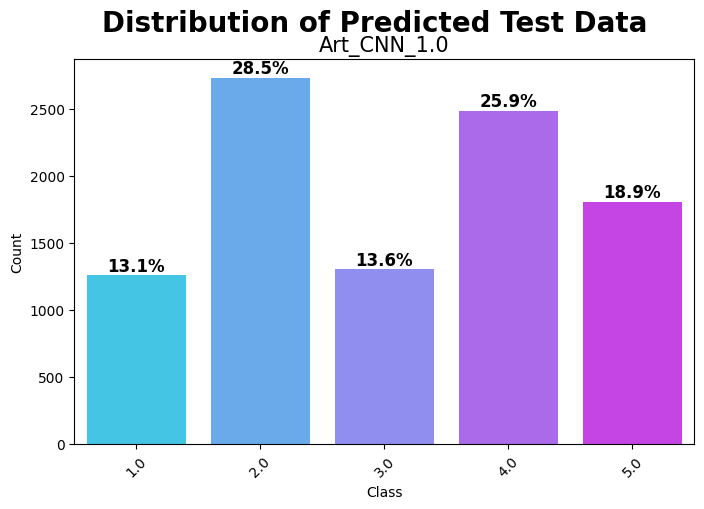

In [ ]:
predicted_counts = {class_name: 0 for class_name in dataset.classes}

for pred in all_preds:
    predicted_counts[dataset.classes[pred]] += 1

total_preds = sum(predicted_counts.values())

df_preds = pd.DataFrame(list(predicted_counts.items()), columns=['Class', 'Count'])

plt.figure(figsize=(8, 5))
ax = sns.barplot(x='Class', y='Count', data=df_preds, palette="cool")

for p in ax.patches:
    percentage = (p.get_height() / total_preds) * 100 
    ax.annotate(f'{percentage:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

plt.suptitle("Distribution of Predicted Test Data", fontsize=20, fontweight='bold')
plt.xticks(rotation=45)
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [ ]:
def class_pred_hist(label):
    true_labels = [testset_simple[i][1] for i in range(len(testset_simple))]

    class_indices = [i for i, true_label in enumerate(true_labels) if true_label == label]

    class_predictions = [all_preds[i] for i in class_indices]

    predicted_counts_class = {class_name: 0 for class_name in dataset.classes}
    for pred in class_predictions:
        predicted_counts_class[dataset.classes[pred]] += 1

    df_class_preds = pd.DataFrame(list(predicted_counts_class.items()), columns=['Class', 'Count'])

    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")

    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='bottom', fontsize=12, fontweight='bold', color='black')

    plt.suptitle("Predictions for Data Points in Class "+str(label+1), fontsize=20, fontweight='bold')
    plt.xticks(rotation=45)
    plt.xlabel("Predicted Class")
    plt.ylabel("Count")
    plt.show()

/tmp/ipykernel_4044303/2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


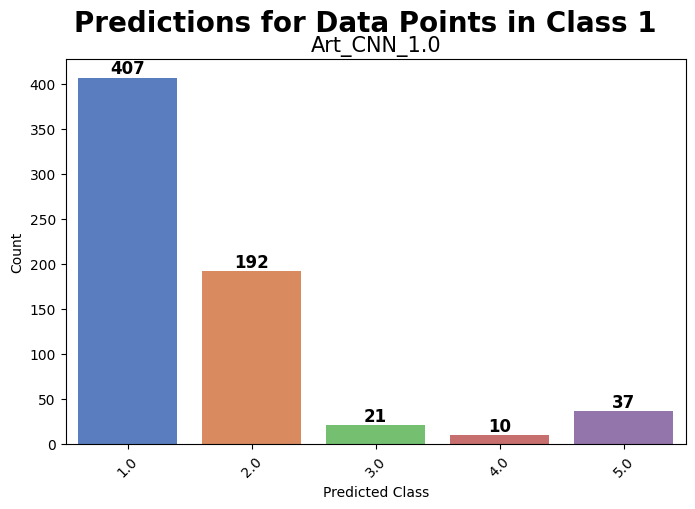

In [14]:
class_pred_hist(0)

/tmp/ipykernel_4044303/2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


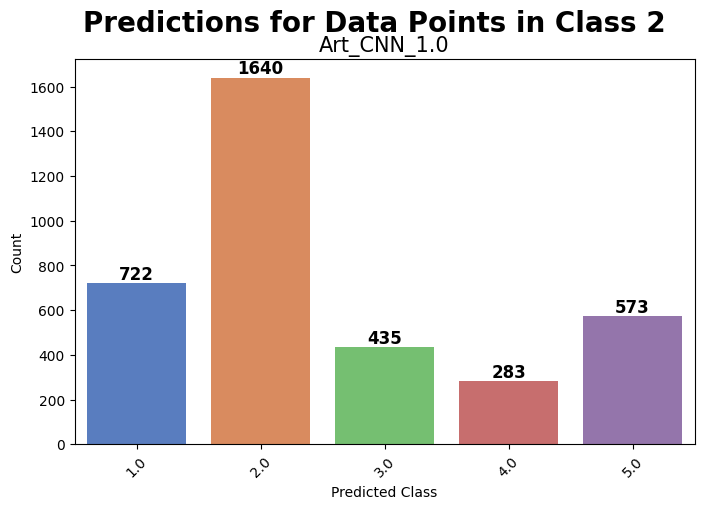

In [15]:
class_pred_hist(1)

/tmp/ipykernel_4044303/2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


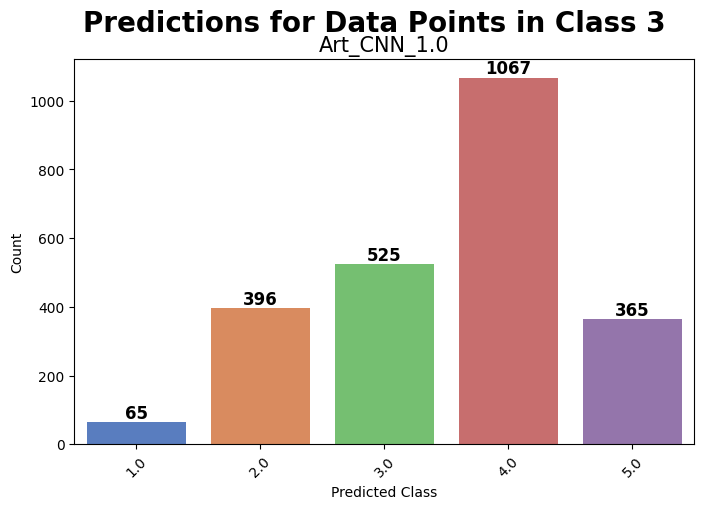

In [16]:
class_pred_hist(2)

/tmp/ipykernel_4044303/2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


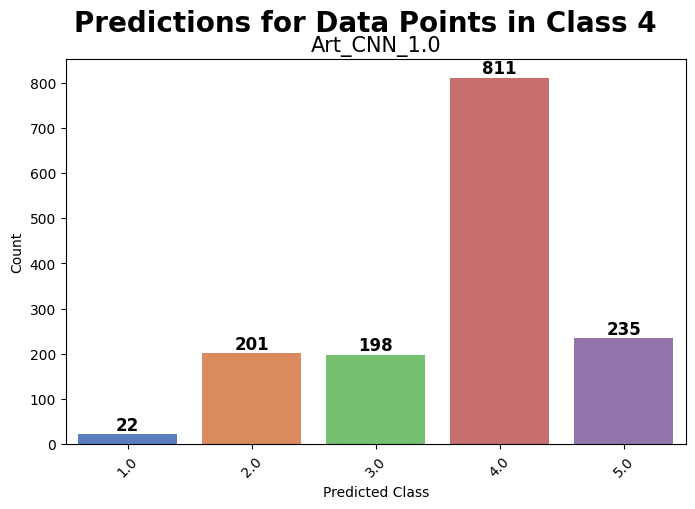

In [17]:
class_pred_hist(3)

/tmp/ipykernel_4044303/2090756873.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='Class', y='Count', data=df_class_preds, palette="muted")


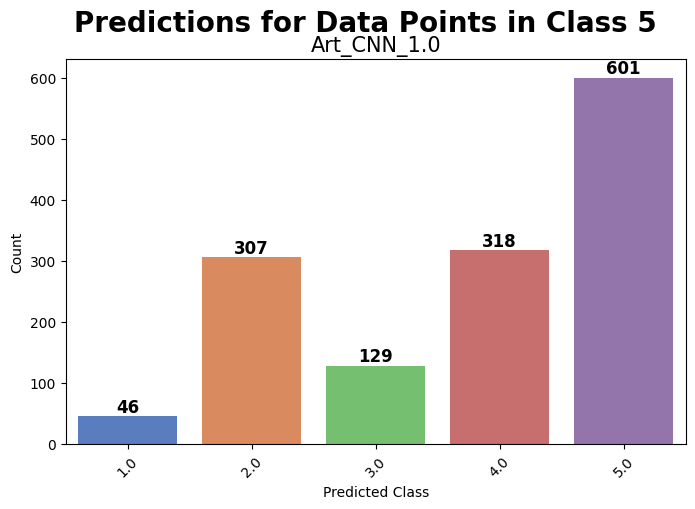

In [18]:
class_pred_hist(4)

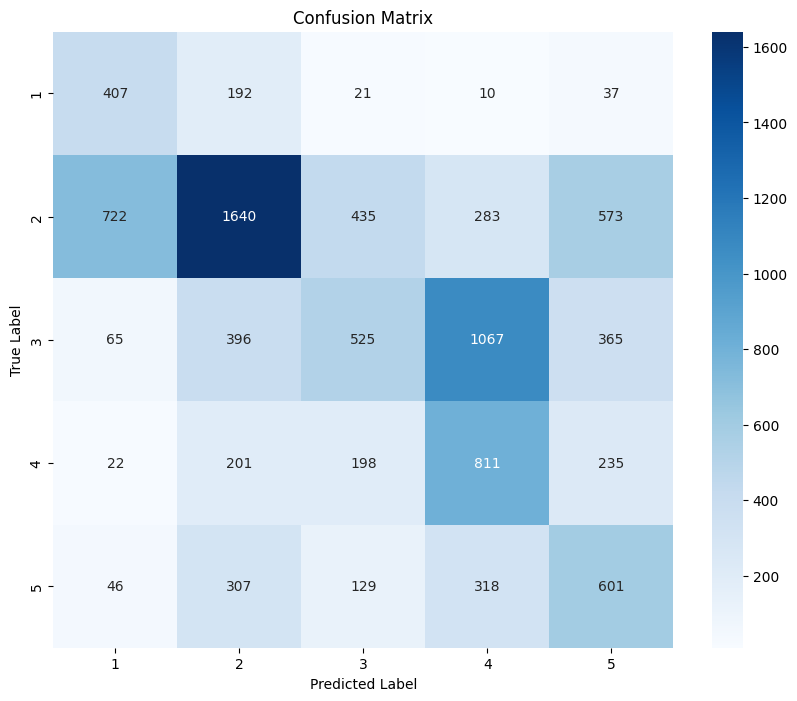

In [ ]:
cm = confusion_matrix(all_true, all_preds)

class_labels = [str(i+1) for i in range(len(cm))]  

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()


In [20]:
def log_embeddings(writer, embeddings_dict, metadata_dict, global_step=0):
    """
    Logs embeddings to TensorBoard.

    Parameters:
      writer (SummaryWriter): TensorBoard writer.
      embeddings_dict (dict): A dictionary where keys are model names (str)
                              and values are embeddings (torch.Tensor of shape [N, D]).
      metadata_dict (dict): A dictionary where keys are model names (str)
                            and values are lists of metadata strings for each sample.
      global_step (int): Global training step (for TensorBoard).
    """
    for name, emb in embeddings_dict.items():
        # .add_embedding expects a 2D tensor and an optional metadata list
        writer.add_embedding(emb, metadata=metadata_dict.get(name, None),
                             tag=name, global_step=global_step)
    print("Embeddings logged to TensorBoard.")


In [ ]:
num_samples = 500

embeddings_custom_np = embeddings_custom.cpu()  # shape: [num_samples, embedding_dim]
metadata_custom = [str(label.item()) for label in labels_custom]

# Create a dictionary of embeddings and metadata
embeddings_dict = {
    "custom": embeddings_custom_np,
}
metadata_dict = {
    "custom": metadata_custom,
}

log_dir = r"runs/embeddings_2"
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
writer = SummaryWriter(log_dir)

log_embeddings(writer, embeddings_dict, metadata_dict, global_step=0)
writer.close()

print("\nTo visualize the embeddings, run in a terminal:\n\n tensorboard --logdir=runs/embeddings\n")


Embeddings logged to TensorBoard.

To visualize the embeddings, run in a terminal:

 tensorboard --logdir=runs/embeddings

